## Convert imaging data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from showit import image

In [4]:
import thunder

In [5]:
from numpy import array, concatenate
from os.path import join, exists
from os import mkdir, makedirs
import json

###Set directory and session information

In [6]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [7]:
key = '2016-02-12'
name = 'anm-0333011'

In [8]:
framesPerVolume = 1

In [9]:
path = join(directory, 'unprocessed', 'images', key, name)
print path
print exists(path)

/tier2/freeman/Nick/lfov.calibration/unprocessed/images/2016-02-12/anm-0333011
True


###Load file data

Each tiff file is automatically truncated to have integer number of volumes

In [10]:
import os

In [11]:
import os
os.listdir(path)

['VolumeLarge_00001_00001.tif',
 'stripe_00001_00001.tif',
 'Volume_00001_00001.tif',
 'stripe_00004_00001.tif',
 'tileLight_00001_00001.tif',
 'square_00001_00001.tif',
 'stripe_00003_00001.tif',
 'squareS_00001_00001.tif',
 'file_00271_00001.tif',
 'stripe_00002_00001.tif']

In [13]:
data = thunder.images.fromtif(path + '/Volume_00001_00001.tif', nplanes=framesPerVolume)

In [23]:
Y = data.values

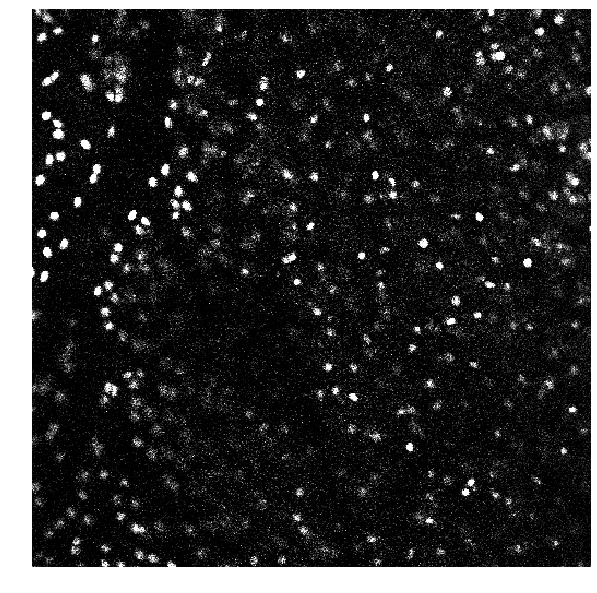

In [35]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(Y[16,:,:], clim=(0, 1000), ax=ax)

In [49]:
avg = thunder.images.fromarray(data.values.reshape((10,16,512,512)).mean(axis=0))

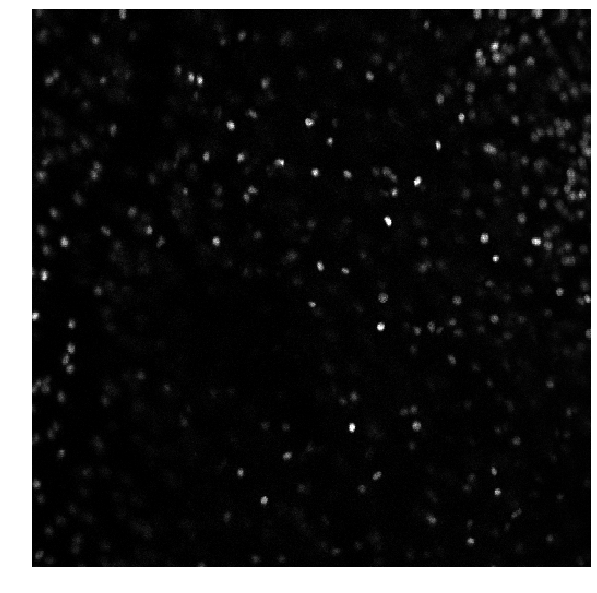

In [61]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(avg.values[7,:,:], clim=(0, 3000), ax=ax)

###Reshape ROI data

In [ ]:
data

In [11]:
corrected = data

In [12]:
lines = 512
n = 2
gap = (data.shape[1] - lines*n)/(n-1)

def split(oim):
    im = array([oim[lines*i + gap*i: lines*(i + 1) + gap*i, 0:lines] for i in range(n)])
    return im.transpose(1, 2, 0)

corrected = thunder.images.fromrdd(data.tordd().mapValues(split))

In [27]:
lines = 1024
n = 2
gap = (data.shape[1] - lines*n)/(n-1)

def split(oim):
    im = array([oim[lines*i + gap*i: lines*(i + 1) + gap*i, 0:lines] for i in range(n)])
    return im.transpose(1, 2, 0)

corrected = thunder.images.fromrdd(data.tordd().mapValues(split))

In [14]:
im = data.values().first()
width = 5000
order = [7, 6, 8, 5, 0, 4, 1, 3, 2]

n = len(order)
gap = (im.shape[0] - width*n)/(n-1)

def split(oim):
    im = [oim[width*order[i] + gap*order[i]: width*(order[i] + 1) + gap*order[i], 0:width] for i in range(n)]
    return concatenate(im,axis=1)

corrected = Images(data.rdd.mapValues(split))

###Save binary data

In [13]:
savepath = join(directory, 'processed', name, key, 'images')
if not exists(savepath):
    makedirs(savepath)

In [14]:
corrected.tobinary(savepath, overwrite=True)

Append number of volumes to conf.json

In [15]:
with open(savepath + '/conf.json') as path:
    conf = json.load(path)

In [16]:
conf['volumes'] = corrected.count()
conf['framesPerVolume'] = framesPerVolume

In [17]:
with open(savepath + '/conf.json', 'w') as path:
    json.dump(conf, path)

### Inspect data

In [18]:
mean = corrected.mean().toarray()

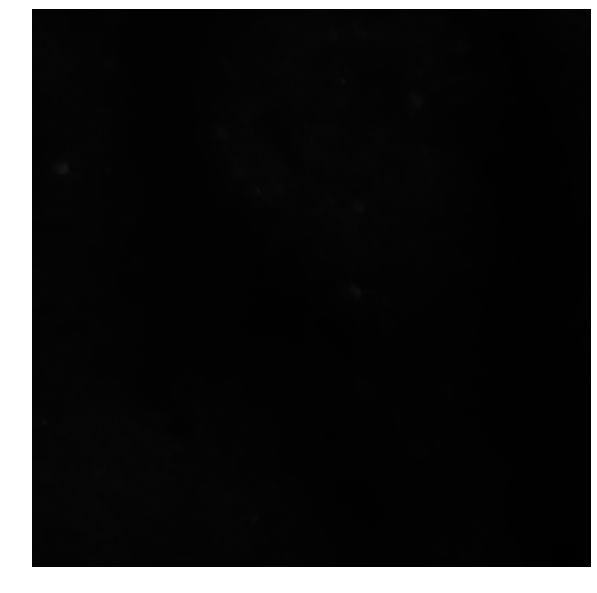

In [19]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(mean[:,:,1], clim=(0, 2024), ax=ax)